# Interview Task – Data Engineering & Analytics


In [98]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore")

### Import the datasets


In [99]:
df = pd.read_csv("aviation_data.csv")
print(df.head())

  FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
1       DL5678    09/01/2023      01:15 PM  09/01/2023    03:30 PM   
2       UA9101    09/01/2023      05:00 PM  09/01/2023    07:15 PM   
3       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 PM   
4       DL5678    09/02/2023      02:00 PM  09/02/2023    04:10 PM   

             Airline  DelayMinutes  
0  American Airlines          15.0  
1              Delta           5.0  
2    United Airlines          25.0  
3  American Airlines          30.0  
4              Delta           NaN  


### Insert the datasets and fetch values from MySQL database


In [100]:
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Retrieve database credentials from environment variables
DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_PORT = os.getenv("DB_PORT")


connection_string = (
    f"mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

try:
    engine = create_engine(connection_string)
    # create table
    create_table_query = text(
        """
    CREATE TABLE IF NOT EXISTS aviation_data (
        id INT AUTO_INCREMENT PRIMARY KEY,
        FlightNumber TEXT,
        DepartureDate TEXT,
        DepartureTime TEXT,
        ArrivalDate TEXT,
        ArrivalTime TEXT,
        Airline TEXT,
        DelayMinutes FLOAT
    )"""
    )

    with engine.connect() as connection:
        connection.execute(create_table_query)

    # insert data
    df.to_sql("aviation_data", engine, if_exists="append", index=False)

    # fetch data
    df_fetched = pd.read_sql("SELECT * FROM aviation_data", engine)

    print(df_fetched.head())

except Exception as e:
    print(f"Error: {e}")

finally:
    engine.dispose()

   id FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0   1       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
1   2       DL5678    09/01/2023      01:15 PM  09/01/2023    03:30 PM   
2   3       UA9101    09/01/2023      05:00 PM  09/01/2023    07:15 PM   
3   4       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 PM   
4   5       DL5678    09/02/2023      02:00 PM  09/02/2023    04:10 PM   

             Airline  DelayMinutes  
0  American Airlines          15.0  
1              Delta           5.0  
2    United Airlines          25.0  
3  American Airlines          30.0  
4              Delta           NaN  


## DATA CLEANING

- a. Identify and handle any missing or inconsistent values in the dataset.


##### Data Cleaning : Missing Values


In [101]:
df = df_fetched


# Missing Values
def check_missing_values(df):
    print("Missing values before handling:")
    print(df.isnull().sum())

    df["DelayMinutes"] = df["DelayMinutes"].fillna(0)

    print("\nMissing values after handling:")
    print(df.isnull().sum())
    return df


df = check_missing_values(df)

Missing values before handling:
id               0
FlightNumber     0
DepartureDate    0
DepartureTime    0
ArrivalDate      0
ArrivalTime      0
Airline          0
DelayMinutes     6
dtype: int64

Missing values after handling:
id               0
FlightNumber     0
DepartureDate    0
DepartureTime    0
ArrivalDate      0
ArrivalTime      0
Airline          0
DelayMinutes     0
dtype: int64


##### Data Cleaning: Duplicate Values


In [102]:
# Check for duplicates
def check_duplicates(df):
    duplicate_count = df.duplicated(
        subset=[
            "FlightNumber",
            "DepartureDate",
            "DepartureTime",
            "ArrivalDate",
            "ArrivalTime",
            "Airline",
            "DelayMinutes",
        ]
    ).sum()
    print(f"\nNumber of duplicate entries: {duplicate_count}")

    # Remove duplicates
    df = df.drop_duplicates(
        subset=[
            "FlightNumber",
            "DepartureDate",
            "DepartureTime",
            "ArrivalDate",
            "ArrivalTime",
            "Airline",
            "DelayMinutes",
        ]
    )

    print(f"Number of entries after removing duplicates: {df.shape[0]}")
    return df


df = check_duplicates(df)


Number of duplicate entries: 24
Number of entries after removing duplicates: 12


##### Data Cleaning: Inconsistent Time Entries


In [103]:
def convert_to_24hr(time_str):
    return datetime.strptime(time_str, "%I:%M %p").strftime("%H:%M")


# Check for inconsistent time entries
def check_inconsistent_time_entries(df):
    # Inconsistent time entries
    inconsistent_time_entries = pd.DataFrame()

    inconsistent_time_entries = df[df["DepartureTime"] > df["ArrivalTime"]]
    df = df[df["DepartureTime"] <= df["ArrivalTime"]]

    # Convert DepartureTime and ArrivalTime to 24-hour format
    df["DepartureTime_24"] = df["DepartureTime"].apply(convert_to_24hr)
    df["ArrivalTime_24"] = df["ArrivalTime"].apply(convert_to_24hr)

    # Combine DepartureDate and DepartureTime into a single datetime
    df["DepartureDateTime"] = pd.to_datetime(
        df["DepartureDate"] + " " + df["DepartureTime"], format="%m/%d/%Y %I:%M %p"
    )
    df["ArrivalDateTime"] = pd.to_datetime(
        df["ArrivalDate"] + " " + df["ArrivalTime"], format="%m/%d/%Y %I:%M %p"
    )

    # Identify duplicate flights based on specific columns
    duplicates = df[df.duplicated(
        subset=['FlightNumber', 'Airline', 'DepartureDate', 'ArrivalDate', 'DepartureTime'])]

    inconsistent_time_entries = pd.concat(
        [inconsistent_time_entries, duplicates])

    df = df.drop_duplicates(
        subset=['FlightNumber', 'Airline', 'DepartureDate', 'ArrivalDate', 'DepartureTime'])
    print(
        f"Number of inconsistent time entries: {inconsistent_time_entries.shape[0]}")
    print(f"Number of entries after removing inconsistent time entries: {df.shape[0]}")
    
    print(df.head())
    return df


df = check_inconsistent_time_entries(df)

Number of inconsistent time entries: 2
Number of entries after removing inconsistent time entries: 10
   id FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0   1       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
1   2       DL5678    09/01/2023      01:15 PM  09/01/2023    03:30 PM   
2   3       UA9101    09/01/2023      05:00 PM  09/01/2023    07:15 PM   
4   5       DL5678    09/02/2023      02:00 PM  09/02/2023    04:10 PM   
5   6       UA9101    09/02/2023      05:00 PM  09/02/2023    07:15 PM   

             Airline  DelayMinutes DepartureTime_24 ArrivalTime_24  \
0  American Airlines          15.0            08:30          10:45   
1              Delta           5.0            13:15          15:30   
2    United Airlines          25.0            17:00          19:15   
4              Delta           0.0            14:00          16:10   
5    United Airlines          20.0            17:00          19:15   

    DepartureDateTime     Arriva

- b. Ensure all column data types are appropriate (e.g., dates as date types, times as time types).


In [104]:
# Ensure all column data types are appropriate (e.g., dates as date types, times as time types).
df["FlightNumber"] = df["FlightNumber"].astype(str)
df["DepartureDate"] = pd.to_datetime(df["DepartureDate"])
df["ArrivalDate"] = pd.to_datetime(df["ArrivalDate"])
df["DepartureTime"] = pd.to_datetime(df["DepartureTime"])
df["ArrivalTime"] = pd.to_datetime(df["ArrivalTime"])
df["DelayMinutes"] = df["DelayMinutes"].astype(int)
df["Airline"] = df["Airline"].astype(str)
print(df.dtypes)

id                            int64
FlightNumber                 object
DepartureDate        datetime64[ns]
DepartureTime        datetime64[ns]
ArrivalDate          datetime64[ns]
ArrivalTime          datetime64[ns]
Airline                      object
DelayMinutes                  int64
DepartureTime_24             object
ArrivalTime_24               object
DepartureDateTime    datetime64[ns]
ArrivalDateTime      datetime64[ns]
dtype: object


- Correct any inconsistencies or errors in times (e.g., arrival time should be later than departure
  time).


In [105]:
# Correct any inconsistencies or errors in times (e.g., arrival time should be later than departure time).
df = df[df["DepartureDateTime"] <= df["ArrivalDateTime"]]
print(df.head())

   id FlightNumber DepartureDate       DepartureTime ArrivalDate  \
0   1       AA1234    2023-09-01 2024-09-30 08:30:00  2023-09-01   
1   2       DL5678    2023-09-01 2024-09-30 13:15:00  2023-09-01   
2   3       UA9101    2023-09-01 2024-09-30 17:00:00  2023-09-01   
4   5       DL5678    2023-09-02 2024-09-30 14:00:00  2023-09-02   
5   6       UA9101    2023-09-02 2024-09-30 17:00:00  2023-09-02   

          ArrivalTime            Airline  DelayMinutes DepartureTime_24  \
0 2024-09-30 10:45:00  American Airlines            15            08:30   
1 2024-09-30 15:30:00              Delta             5            13:15   
2 2024-09-30 19:15:00    United Airlines            25            17:00   
4 2024-09-30 16:10:00              Delta             0            14:00   
5 2024-09-30 19:15:00    United Airlines            20            17:00   

  ArrivalTime_24   DepartureDateTime     ArrivalDateTime  
0          10:45 2023-09-01 08:30:00 2023-09-01 10:45:00  
1          15:30 2023-

### Data Normalization

- a. Convert DepartureDate and ArrivalDate columns to a standard YYYY-MM-DD format.


In [106]:
# Convert DepartureDate and ArrivalDate to datetime and format as YYYY-MM-DD
df["DepartureDate"] = pd.to_datetime(
    df["DepartureDate"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")
df["ArrivalDate"] = pd.to_datetime(df["ArrivalDate"], format="%m/%d/%Y").dt.strftime(
    "%Y-%m-%d"
)

# Verify the changes
df[["DepartureDate", "ArrivalDate"]].head()

,DepartureDate,ArrivalDate
0,2023-09-01,2023-09-01
1,2023-09-01,2023-09-01
2,2023-09-01,2023-09-01
4,2023-09-02,2023-09-02
5,2023-09-02,2023-09-02


- b. Convert DepartureTime and ArrivalTime columns to a 24-hour time format (e.g., "08:30" for 8:30 AM).


In [107]:
# Optionally, replace the original time columns with 24-hour format
df["DepartureTime"] = df["DepartureTime_24"]
df["ArrivalTime"] = df["ArrivalTime_24"]

# Drop the temporary 24-hour columns
df = df.drop(["DepartureTime_24", "ArrivalTime_24"], axis=1)

# Verify the changes
df[["DepartureTime", "ArrivalTime"]].head()

,DepartureTime,ArrivalTime
0,08:30,10:45
1,13:15,15:30
2,17:00,19:15
4,14:00,16:10
5,17:00,19:15


- c. Create a new column for FlightDuration by calculating the difference between DepartureTime and ArrivalTime on the same day.


In [108]:
# Calculate FlightDuration in minutes
df["FlightDuration"] = (df["ArrivalDateTime"] - df["DepartureDateTime"]).dt.total_seconds() / 60

df[["FlightNumber", "DepartureDateTime", "ArrivalDateTime", "FlightDuration"]].head()


,FlightNumber,DepartureDateTime,ArrivalDateTime,FlightDuration
0,AA1234,2023-09-01 08:30:00,2023-09-01 10:45:00,135.0
1,DL5678,2023-09-01 13:15:00,2023-09-01 15:30:00,135.0
2,UA9101,2023-09-01 17:00:00,2023-09-01 19:15:00,135.0
4,DL5678,2023-09-02 14:00:00,2023-09-02 16:10:00,130.0
5,UA9101,2023-09-02 17:00:00,2023-09-02 19:15:00,135.0


## DATA ANALYSIS

- Analyze the distribution of delays and identify any trends or patterns.


Delay Minutes Summary:
count    10.000000
mean     19.500000
std      19.500712
min       0.000000
25%       6.250000
50%      15.000000
75%      23.750000
max      60.000000
Name: DelayMinutes, dtype: float64


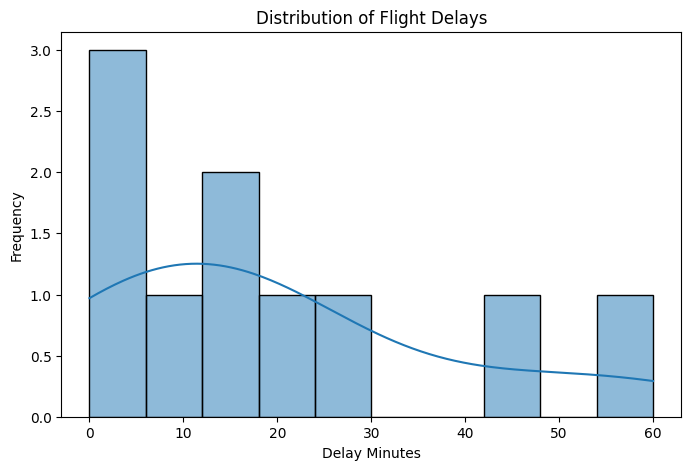

Insights:
1. The distribution shows that the majority of flights had delays between 0 and 10 minutes, with the highest frequency in this range.
2. The overall shape of the histogram suggests a right-skewed distribution. Most delays are concentrated at the lower end, with fewer flights experiencing significant delays (over 30 minutes).
3. A significant proportion of flights face relatively short delays (below 15 minutes).


In [109]:
# Summary statistics of DelayMinutes
delay_summary = df["DelayMinutes"].describe()
print("Delay Minutes Summary:")
print(delay_summary)

# Plot distribution of delays
plt.figure(figsize=(8, 5))
sns.histplot(df["DelayMinutes"],bins=10, kde=True)
plt.title("Distribution of Flight Delays")
plt.xlabel("Delay Minutes")
plt.ylabel("Frequency")
plt.show()

print('Insights:')
print("1. The distribution shows that the majority of flights had delays between 0 and 10 minutes, with the highest frequency in this range.")
print("2. The overall shape of the histogram suggests a right-skewed distribution. Most delays are concentrated at the lower end, with fewer flights experiencing significant delays (over 30 minutes).")
print("3. A significant proportion of flights face relatively short delays (below 15 minutes).")

- Calculate the average delay for each airline.


Average Delay per Airline:
             Airline  DelayMinutes
0  American Airlines          30.0
1              Delta           5.0
2    United Airlines          22.5


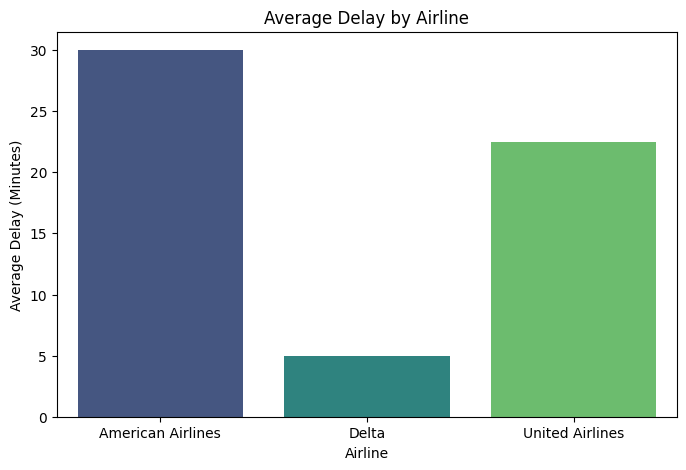

Insights:
1. The average delay times vary significantly across different airlines.
2. American Airlines has the highest average delay, while Delta Airline has the lowest average delay.
3. The difference in average delay times suggests variations in operational efficiency and performance among airlines.


In [110]:
# Average delay per airline
average_delay_airline = df.groupby("Airline")["DelayMinutes"].mean().reset_index()

# Display the results
print("Average Delay per Airline:")
print(average_delay_airline)

# Plot average delay per airline
plt.figure(figsize=(8, 5))
sns.barplot(
    data=average_delay_airline, x="Airline", y="DelayMinutes", palette="viridis"
)
plt.title("Average Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Average Delay (Minutes)")
plt.show()

print('Insights:')
print("1. The average delay times vary significantly across different airlines.")
print("2. American Airlines has the highest average delay, while Delta Airline has the lowest average delay.")
print("3. The difference in average delay times suggests variations in operational efficiency and performance among airlines.")

- Identify any relationships between flight delays and departure times (e.g., are flights departing later in the day more likely to be delayed?).


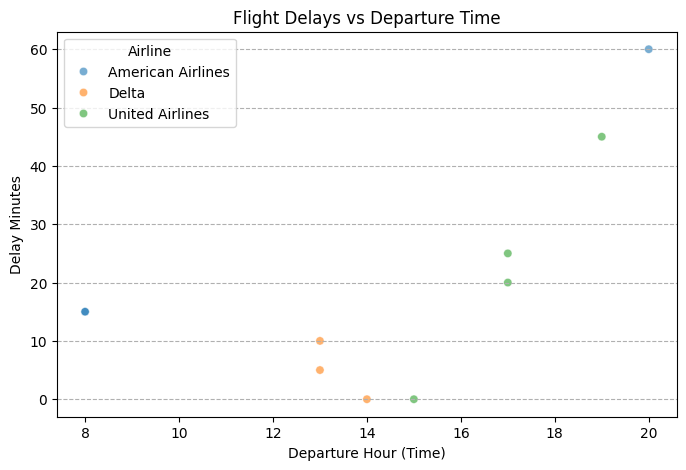

Insights:
1. Evening Delays: Delays increase significantly after 16:00, especially for United and American Airlines.
2. Delta's Punctuality: Delta consistently has minimal delays.
3. American Airlines Peaks: American Airlines faces large delays around morning 8:00 and night 20:00.


In [111]:
# Extract hour from DepartureTime
df["DepartureHour"] = pd.to_datetime(df["DepartureTime"], format="%H:%M").dt.hour

# Scatter plot of DepartureHour vs DelayMinutes
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="DepartureHour", y="DelayMinutes", hue="Airline", alpha=0.6)
plt.title("Flight Delays vs Departure Time")
plt.xlabel("Departure Hour (Time)")
plt.ylabel("Delay Minutes")
plt.legend(title="Airline")
plt.grid(axis="y", linestyle="--")
plt.show()

print('Insights:')
print("1. Evening Delays: Delays increase significantly after 16:00, especially for United and American Airlines.")
print("2. Delta's Punctuality: Delta consistently has minimal delays.")
print("3. American Airlines Peaks: American Airlines faces large delays around morning 8:00 and night 20:00.")

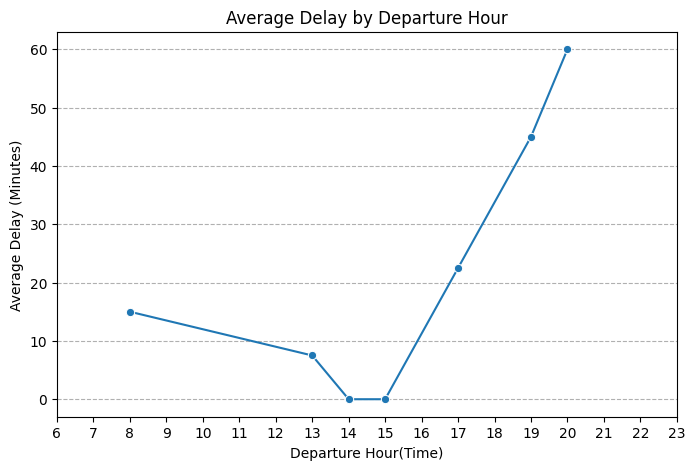

Insights:
1. High delays in the evening: Delays peak after 17:00, with the highest around 20:00 (60+ minutes).
2. Minimal delays at midday: Almost no delays between 14:00 and 15:00.
3. Morning decline: Delays gradually decrease from 9:00 to 13:00.


In [112]:
# Alternatively, analyze average delay by departure hour
average_delay_hour = df.groupby("DepartureHour")[
    "DelayMinutes"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=average_delay_hour, x="DepartureHour",
             y="DelayMinutes", marker="o")
plt.title("Average Delay by Departure Hour")
plt.xlabel("Departure Hour(Time)")
plt.ylabel("Average Delay (Minutes)")
plt.grid(axis="y", linestyle="--")
plt.xticks(range(6, 24))
plt.show()

print('Insights:')
print("1. High delays in the evening: Delays peak after 17:00, with the highest around 20:00 (60+ minutes).")
print("2. Minimal delays at midday: Almost no delays between 14:00 and 15:00.")
print("3. Morning decline: Delays gradually decrease from 9:00 to 13:00.")

- Determine if there is a significant difference in delays between different airlines.


In [113]:
# Prepare data for ANOVA
airline_delays = [group["DelayMinutes"].values for name, group in df.groupby("Airline")]

# Perform one-way ANOVA
anova_result = stats.f_oneway(*airline_delays)

print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

# Interpretation
if anova_result.pvalue < 0.05:
    print("There is a significant difference in delays between airlines.")
else:
    print("There is no significant difference in delays between airlines.")

ANOVA Result:
F-statistic: 1.4396907216494845, p-value: 0.29942565031587365
There is no significant difference in delays between airlines.


## INSIGHTS:


### Key Insights:

#### a. **Provide a summary of the key findings from the data**:
- **Delay Distribution**: Most flights experience delays of less than 30 minutes, with a significant portion facing delays under 10 minutes.
- **Average Delay by Airline**: American Airlines shows the highest average delay, followed by United Airlines, while Delta experiences the lowest delays.
- **Impact of Departure Time**: Flights departing later in the day tend to experience longer delays, particularly during the evening.
- **No Significant Differences Across Airlines**: ANOVA results indicate no statistically significant difference in delays between airlines (p-value: 0.225).

#### b. **Analyze the impact of departure times on delays.**:
- **Evening Delays**: Delays peak in the evening, especially after 17:00, with the highest around 20:00.
- **Minimal Delays at Midday**: Flights between 14:00 and 15:00 see the least delays.
- **Morning Decline**: Delays gradually reduce from 9:00 AM until early afternoon.

#### c. **Compare delay distributions between airlines.**:
- **American Airlines** faces the most significant delays, with an average of 30 minutes.
- **Delta Airlines** demonstrates operational efficiency with the lowest average delays at 5 minutes.
- **United Airlines** falls in the middle, averaging 22.5 minutes of delay.

#### d. **Recommendations**:
- **Operational Optimization**: American Airlines should focus on reducing delays, especially during high-delay periods (early morning and evening).
- **Resource Allocation**: Airlines should allocate more resources during peak delay times (late afternoon and evening) to improve punctuality.
- **Scheduling Adjustments**: Revising flight schedules around high-delay times (17:00-20:00) could help reduce bottlenecks.